COMP 215 - LAB 6 (Game of Life)
-----------------------------------------------
#### Name: Alex Wagstaff, with assistance from Ben Blair
#### Date: March 2023

This lab exercise is an introduction to [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) discovered and studied by [John Conway](https://en.wikipedia.org/wiki/John_Horton_Conway).

**New Python concepts**:
   * 2D numpy [array](https://numpy.org/doc/stable/reference/generated/numpy.array.html)
   * basic [array operations](https://www.pluralsight.com/guides/overview-basic-numpy-operations)

**New Computation concepts**:
   * [2D sliding dot product](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html)
   * [Animation](https://matplotlib.org/stable/api/animation_api.html)

**Credits**:
    Code examples based on [Think Complexity, 2nd edition](https://thinkcomplex.com).
    Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

As usual, the first code cell simply imports all the modules we'll be using...

In [1]:
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.signal import correlate2d
import random


%matplotlib inline
# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

A reusable function for plotting 2D numpy.array as an image...

In [2]:
DEFAULT_IMSHOW_OPTIONS = dict(
    cmap = 'Blues',
    interpolation='none',
    origin='upper',
)

def plot_2D_array(array, axes=None, title='', **options):
    """ Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue. """
    axes = axes or plt.gca()   # If not axes are provided, draw on current axes
    axes.set_title(title)
    axes.set_xticks([], [])  # remove axes tick marks
    axes.set_yticks([], [])
    options = {**DEFAULT_IMSHOW_OPTIONS, **options}
    axes.imshow(array, **options)

## Life Fundamentals
Both the textbook and our week6 notebooks develop some fundamental operations for simulating the Game of Life.
Some of the code from `week6.ipynb` is reproduced here without deriving all the ideas - review `week6.ipynb` notebook for the full story.
The sliding dot product algorithm in `step` is implemented with [scipy.signal.correlate2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html).  It's behaviour is identical to the derivation in `week6.ipynb`.

#### Notes
* we use `correlate2d(state, kernel, mode='same', boundary='wrap')` to pad state matrix with 1 value around perimeter from the opposite side of the matrix.
* since the rule is a 1D `np.array`, we use "vector indexing" here to set the 'live' state transitions:  `next_state[[3, 12, 13]] = 1`

In [3]:
class Life2D:
    """ An basic 2D Cellular Automata that implementes Conway's Game of Life """
    kernel = np.array([[1, 1, 1],
                       [1, 10, 1],
                       [1, 1, 1]])

    next_state = np.zeros(100, dtype=np.uint8)
    next_state[[3, 12, 13]] = 1

    def __init__(self, n_rows, n_cols=None):
        """ Construct a n_rows x n_cols 2D CA """
        n_cols = n_cols or n_rows  # i.e., n_cols if n_cols is not None and n_cols != 0 else n_rows
        self.state = np.zeros(shape=(n_rows, n_cols), dtype=np.uint8)

    def step(self):
        """Executes one time step. """
        transitions = correlate2d(self.state, self.kernel, mode='same', boundary='wrap')
        self.state = self.next_state[transitions]

    def draw(self, axes=None, step=''):
        axes = axes or plt.gca()   # use pyplot's current axes if none are provided.
        plot_2D_array(self.state, axes, title=f"Conway's Game of Life {step}")

### Visualizing a 2D simulation model
For 1D CAs, we could use a 2D image to visualize the CA progression over time.
For 2D CAs, we could try using time as a 3rd axis to generate a 3D visualziation, but without VR, its hard to explore a 3D visualization.
Instead, we'll use a simple 2D ["stop motion" animation](https://en.wikipedia.org/wiki/Animation).
Here is a generic class that animates any 2D model that provides step() and draw() methods, and uses matplotlib to render its state.

See [Matplotlib animation in Jupyter](https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/) by our textbook author for a discussion of the pros and cons of various animation techniques in jupyter notebooks.

In [4]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number
    """

    def __init__(self, model, frames=50, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            self.model.step()
        self.model.draw(self.ax, step=step)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()          # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)     # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()               # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

### Sample usage
Animate a single glider...

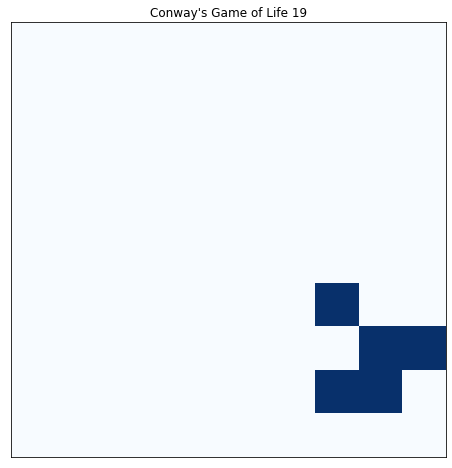

In [5]:
size = 10
life = Life2D(size)
glider = np.array([[0, 1, 0], [0, 0, 1], [1, 1, 1]], dtype=np.uint8)
life.state[1:4, 2:5] = glider             # bad idea to alter an objects state directly!  We'll improve it in Ex. 3
gol = Animation2D(life, frames=20)
gol.animate()

## Exercise 1:  Enumerate all Elementary 2D CA's
 * how many unique states are there for a 3x3 (9 cell) neighbourhood?
 * how many unique “rules” are there? (where a rule provides a mapping for each possible neighbourhood state to the output for the centre cell)
 * how does this number compare, for example, to the [number of atoms in the observable universe?](https://en.wikipedia.org/wiki/Observable_universe#Matter_content%E2%80%94number_of_atoms)
 * would it be a reasonable goal to conduct an experiment like Wolfram’s for 2D CA’s?
 * propose a numbering scheme for these rules, analogous to Wolfram’s rule numbers
 * how might we go about determining which rule number corresponds to Conway’s GoL?
   (I’m not asking for the number, but rather for a method you could use to find it.)

In [6]:
# Solutions for Ex. 1
size = 3
cells = size**2
pos_states = 2**cells
print(f'    ///Numbers given as xe+y are in scientific notation due to the size of the numbers///')

print(f'Q1: For a {size}x{size} array containing {cells} cells, there are {pos_states} possible states.')
print('\n')
unique_rules = 2**pos_states
print(f'Q2: An array containing {cells} cells can produce {unique_rules:.2e} unique rules')
print('\n')
Ed_num = 10**80
rule_atom_percent = (Ed_num/unique_rules)*100
print(f'Q3: There are supposedly {Ed_num:.0e} atoms in the universe, known as the Eddington Number.')
print(f'    The Eddington number is {rule_atom_percent:.2}% the size of the number of unique rules produced by an array containing {cells} cells.')
print('\n')
print(f'Q4: Assuming that the number of unique rules calculated is accurate, even if you could process one unique rule per second it would take \n    significantly more time to make a dent than there have been seconds since the Big Bang. ')
print('\n')
print(f'Q5: Keeping it similar to Wolframs, using an integer produced by a reversed 18-bit binary string can be used to depict the rule. The 18-bits come from\n    the two rule conditions and their positions. 9 bits for the birth condition, 9 bits for the survival conditions. This is a commonly used practice\n    known as rule integers.')
print('\n')
print(f'Q6: Rule integer notation uses 9 bits to depict the birth conditions, and 9 following bits to depict the survival conditions.\n    As Conway\'s game of life has a cell born when it has 3 neighbours, and cells survive if they have 2 or 3 neighbours, generating the binary string\n    000100000001100000, which is then reversed and turned into an integer like Wolfram\'s method. Conway\'s Game of life rule integer is 6152')

    ///Numbers given as xe+y are in scientific notation due to the size of the numbers///
Q1: For a 3x3 array containing 9 cells, there are 512 possible states.


Q2: An array containing 9 cells can produce 1.34e+154 unique rules


Q3: There are supposedly 1e+80 atoms in the universe, known as the Eddington Number.
    The Eddington number is 7.5e-73% the size of the number of unique rules produced by an array containing 9 cells.


Q4: Assuming that the number of unique rules calculated is accurate, even if you could process one unique rule per second it would take 
    significantly more time to make a dent than there have been seconds since the Big Bang. 


Q5: Keeping it similar to Wolframs, using an integer produced by a reversed 18-bit binary string can be used to depict the rule. The 18-bits come from
    the two rule conditions and their positions. 9 bits for the birth condition, 9 bits for the survival conditions. This is a commonly used practice
    known as rule integers.


Q

## Exercise 2: random_life
Extend the Life2D class defined above to allow the game to be initialized with a random start state.
The liklihood of any given cell being initialized to "alive" is given by $p$.
*Hint*: we did this exact exercise for a 1D array in lab 5

In [7]:
# Solution for Ex. 2

class BetterLife2D(Life2D):
    """ Improvements on the basic Life2D model """

    def randomize_state(self, p):
        """ Randomize the state of this GoL, where probability of a "live" cell is p """
        self.shape = np.shape(self.state)
        self.randomized = np.random.random(size=self.shape)
        self.state = (self.randomized<p).astype(int)
    
    # Ex3 BetterLife2D extension
    def load_pattern(self,x,y,pattern): # Ben helped significantly with this section
      """Loads a pattern into array at specified coords"""
      pat = pattern_get(pattern)
      n_rows,n_cols = pat.shape
      self.state[x:x+n_rows, y:y+n_cols] = pat
        

def random_life(n_rows, n_cols=None, p=0.5):
    """ Return a Life2D object of given dimensions with initial randomized state where "live" cells have probability p """
    n_cols = n_cols or n_rows
    a= BetterLife2D(n_rows,n_cols)
    a.randomize_state(p)
    return a



### Experiment
Run a small experiment to see if you can identify any relationship between $p$, the probability of a live cell in the initial grid, and the time it takes for the GoL pattern to stabilize.

High probabilities of live cells cause the system to completely dissapate after a single step. Medium probabilites, such as p=0.5, maintain some form of chaos for significantly longer. Low probabilites reach a stable, unchanging state fairly quickly. 

In [8]:
rand_life=random_life(10,p=0.9)
gol=Animation2D(rand_life,frames=20)
gol.show()

## Exercise 3: Load Patterns
People have discovered many interesting ["patterns"](https://conwaylife.com/wiki/Category:Patterns) that exhibit various types of behaviours.
A "pattern" is just a small 2D array.
 1. Develop a function that returns a 2D array containing the patterns defined by a single string; and
 2. Add an `load_pattern(x, y, pattern)` method to your BetterLife2D class above to insert patterns into the Life state array
    *Tip*: you can [assign an entire 2D slice of a numpy array](https://www.nickmccullum.com/advanced-python/numpy-indexing-assignment/) in a single assignment statement!   See example in the Sample Usage block above. Try it!

In [9]:
# Here's an example of the glider pattern from above defined in a single string...
glider_pattern = \
    """
    010
    001
    111
    """

# Solution for Ex. 3
def pattern_get(pat):
  pat_lst = pat.split()
  for i in range(len(pat_lst)):
    pat_lst[i] = list(pat_lst[i])
  pat_arr = np.array(pat_lst,dtype=np.uint8)
  return pat_arr

glider = pattern_get(glider_pattern)


### Define some patterns
User your nifty new function to define a few common, interesting patterns (e.g., from the book or other sources)

In [10]:
# define your patterns here
herschel = " 100 111 101 001"
beehive = " 0110 1001 0110"
toad = " 0111 1110 "
gosper_gun = \
  """
  000000000000000000000000100000000000
  000000000000000000000010100000000000
  000000000000110000001100000000000011
  000000000001000100001100000000000011
  110000000010000010001100000000000000
  110000000010001011000010100000000000
  000000000010000010000000100000000000
  000000000001000100000000000000000000
  000000000000110000000000000000000000
  """


### Experiment
Load up a BetterLife2D object with some patterns that interact in some interesting way.
What can we learn from studying interactions like this?   Is anything here applicable to the real world?

Sending a moving pattern such as the basic glider into either an oscillating(toad) or active pattern(herschel) creates something like an explosion. Sending a glider into a static pattern removes all involved active cells. 

Sort of adhears to Newtons Third law of action and reaction. Active patterns can move, where static patterns act as an imoveable object and remove themselves from the simulation.

In [11]:
# code for your experiment here
life=BetterLife2D(20)
life.load_pattern(0,0,glider_pattern)
life.load_pattern(5,5,herschel)
# life.load_pattern(6,6,toad)
# life.load_pattern(6,6,beehive)
# life.load_pattern(0,9,glider_pattern)
# life.load_pattern(9,6,toad)
# life.load_pattern(4,9,toad)
# life.load_pattern(9,9,toad)
# life.load_pattern(0,0,gosper_gun)
gol = Animation2D(life,frames = 30)
gol.show()